# In this notebook, we test the orbital reordering that Block2 uses

In [1]:
import numpy as np
from pyblock2._pyscf.ao2mo import integrals as itg
from pyblock2.driver.core import DMRGDriver, SymmetryTypes

bond_dims = [250] * 4 + [500] * 4
noises = [1e-4] * 4 + [1e-5] * 4 + [0]
thrds = [1e-10] * 8

## Original DMRG algorithm

In [7]:
from pyscf import gto, scf

mol = gto.M(atom="N 0 0 0; N 0 0 1.4", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)
print(f"n Cas: {ncas}")
print(f"orb sym: {orb_sym}")
driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=0)
print('DMRG energy = %20.15f' % energy)

pdm1 = driver.get_1pdm(ket)
pdm2 = np.array(driver.get_2pdm(ket)).transpose(0, 3, 1, 2)
print('Energy from pdms = %20.15f' % (np.einsum('ij,ij->', pdm1, h1e)
    + 0.5 * np.einsum('ijkl,ijkl->', pdm2, driver.unpack_g2e(g2e)) + ecore))

impo = driver.get_identity_mpo()
expt = driver.expectation(ket, mpo, ket) / driver.expectation(ket, impo, ket)
print('Energy from expectation = %20.15f' % expt)

n Cas: 10
orb sym: [5, 0, 0, 5, 0, 6, 7, 2, 3, 5]
DMRG energy = -107.623174178084156


ValueError: axes don't match array

## Reordering applied

In [9]:
import pyscf
from pathlib import Path 

mol = gto.M(atom="N 0 0 0; N 0 0 2.2", basis="sto3g", symmetry="d2h", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)
ncas, n_elec, spin, ecore, h1e_orig, g2e_orig, orb_sym_orig = itg.get_rhf_integrals(mf,
    ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
g2e_orig = driver.unpack_g2e(g2e_orig, n_sites=ncas)

minfos = {}
for method in ["fiedler", "gaopt"]:
    idx = driver.orbital_reordering(h1e_orig, g2e_orig)
    h1e = h1e_orig[idx][:, idx]
    g2e = g2e_orig[idx][:, idx][:, :, idx][:, :, :, idx]
    orb_sym = np.array(orb_sym_orig)[idx]
    print(h1e)
    label = "_orb_optimum"
    filename = "fcidump.N2" + f"{label}"
    pyscf.tools.fcidump.from_integrals(
        "fcidump_output"/Path(filename),
        h1e,
        g2e,
        nmo=ncas,
        nelec=n_elec,
        nuc=ecore,
        ms=spin,
        orbsym=None,
        tol=1E-8,
        float_format=' %.16g',
    )

    driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)
    mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, iprint=0)
    ket = driver.get_random_mps(tag="GS", bond_dim=250, nroots=1)
    energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
        thrds=thrds, iprint=0)
    print('Method = %s DMRG energy = %20.15f' % (method, energy))
    minfos[method] = driver.get_orbital_interaction_matrix(ket)

[[-6.54851804e+00  0.00000000e+00  0.00000000e+00  6.94892921e-16
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -6.54851804e+00  6.94892921e-16  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -4.42267277e-17 -6.56232798e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.42267277e-17  0.00000000e+00  0.00000000e+00 -6.56232798e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -6.60188461e+00 -1.89988726e-16 -2.50728594e-01 -7.36743845e-17
   5.26231440e-17 -8.13733319e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -7.85099319e-16 -6.76664245e+00  1.66322952e-16 -3.49113145e-01
   5.02143009e-02 -4.37175734e-17

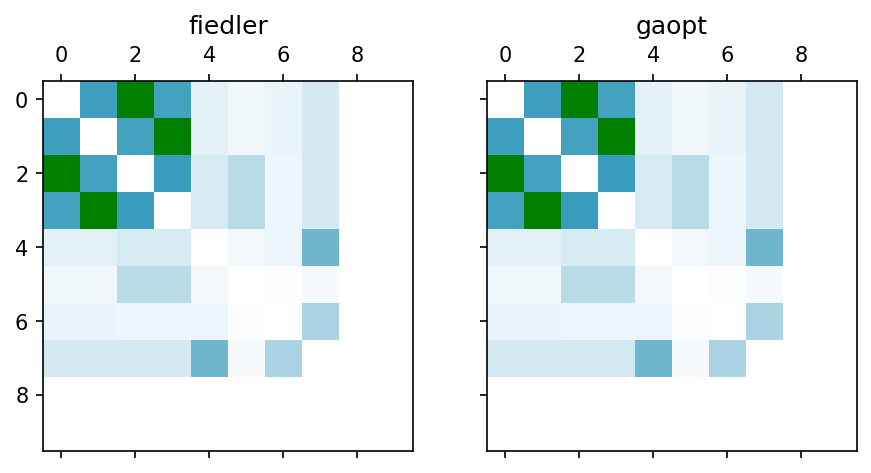

In [5]:
import matplotlib.pyplot as plt
f, axs = plt.subplots(1, 2, sharey=True)
f.set_size_inches(w=14 / 2, h=7 / 2)
for ax, (method, minfo) in zip(axs, minfos.items()):
    ax.matshow(minfo, cmap='ocean_r')
    ax.set_title(method)
plt.gcf().set_dpi(150)
plt.show()

In [8]:
from block2 import FCIDUMP, VectorUInt8
from pyscf import gto, scf, mcscf, lo, tools, ao2mo
from pyscf.mcscf import casci_symm
import scipy.linalg
import scipy.optimize
import numpy as np
mol = gto.M(atom='C 0 0 0; C 0 0 1.2425', basis='ccpvdz', symmetry='d2h')
mf = scf.RHF(mol).run()
mc = mcscf.CASCI(mf, 26, 8)

ncore = mc.ncore
nactorb = mc.ncas


# localize orbitals
def scdm(coeff, overlap):
    aux = lo.orth.lowdin(overlap)
    no = coeff.shape[1]
    ova = coeff.T @ overlap @ aux
    piv = scipy.linalg.qr(ova, pivoting=True)[2]
    bc = ova[:, piv[:no]]
    ova = np.dot(bc.T, bc)
    s12inv = lo.orth.lowdin(ova)
    return coeff @ bc @ s12inv


# sort orbitals by irrep
def irrep_sort(coeff):
    optimal_reorder = [0, 6, 3, 5, 7, 1, 4, 2]  # d2h
    orb_sym = casci_symm.label_symmetry_(mc, mo_coeff_act).orbsym
    orb_opt = [optimal_reorder[x] for x in orb_sym]
    idx = np.argsort(orb_opt)
    return coeff[:, idx], orb_sym[idx]


# HF orbitals (old basis)
mo_coeff_act = mc.mo_coeff[:, mc.ncore:mc.ncore + mc.ncas].copy()
mo_coeff_act, mo_orb_sym = irrep_sort(mo_coeff_act)

# Symmetrized localized orbitals (new basis)
lmo_coeff_act = mo_coeff_act.copy()
for isym in set(mo_orb_sym):
    mask = np.array(mo_orb_sym) == isym
    lmo_coeff_act[:, mask] = scdm(
        mo_coeff_act[:, mask], mol.intor('cint1e_ovlp_sph'))

converged SCF energy = -75.3869023777049
[[-1.16320826e-02  5.54600972e-03  0.00000000e+00  0.00000000e+00
   1.88032769e-02  0.00000000e+00  0.00000000e+00 -3.64688657e-02
  -1.08382507e-01  0.00000000e+00  0.00000000e+00  4.34315312e-01
   0.00000000e+00  0.00000000e+00 -2.37620206e-01 -1.15912464e-17
   0.00000000e+00 -6.21010890e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.21259185e-18 -4.68935770e-01  0.00000000e+00
   0.00000000e+00  3.59034138e-01]
 [ 3.46870868e-01  3.29634616e-01  0.00000000e+00  0.00000000e+00
  -2.52293840e-02  0.00000000e+00  0.00000000e+00  1.41547525e-01
  -1.79222233e-01  0.00000000e+00  0.00000000e+00  1.06086591e+00
   0.00000000e+00  0.00000000e+00 -4.13922907e-01 -2.99950299e-17
   0.00000000e+00 -1.41255369e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -5.78057525e-18 -8.50782635e-01  0.00000000e+00
   0.00000000e+00  8.13523651e-01]
 [ 2.12548685e-01  4.31263071e-01  0.00000000e+00  0.00000000e+00
  -3.66685603e-01  0.00000000e+

In [3]:
# orbital transform rot[old, new]
orb_rot = np.linalg.pinv(mo_coeff_act) @ lmo_coeff_act
assert np.linalg.norm(orb_rot.T - np.linalg.inv(orb_rot)) < 1E-12
assert np.linalg.norm(lmo_coeff_act - mo_coeff_act @ orb_rot) < 1E-12

In [5]:
print(mo_coeff_act)

[[-1.16320826e-02 -4.68935770e-01  1.88032769e-02 -1.15912464e-17
   4.34315312e-01 -1.08382507e-01 -2.21259185e-18 -6.21010890e-01
  -2.37620206e-01  3.59034138e-01 -3.64688657e-02  5.54600972e-03
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.46870868e-01 -8.50782635e-01 -2.52293840e-02 -2.99950299e-17
   1.06086591e+00 -1.79222233e-01 -5.78057525e-18 -1.41255369e+00
  -4.13922907e-01  8.13523651e-01  1.41547525e-01  3.29634616e-01
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.12548685e-01  3.91086260e-01 -3.66685603e-01  2.42805194e-17
  -9.13704421e-01 -8.77394312e-02 -6.67789429e-17  6.80796070e+00
   1.7